In [1]:
from graphnics import *
from xii import *

from numpy import loadtxt
import scipy.interpolate as sp_interpolate
import matplotlib.pyplot as plt

%matplotlib notebook
import seaborn as sns
sns.set()
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.append('../data/')


Missing HsMG for fract norm computing


# Introduction

Cerebrospinal Fluid (CSF) is known to continuously circulate around and inside the brain. Recently, this fact has attracted extensive research interest, due to a theory that the bulk flow of CSF sweeps along metabolic waste, and so functions as a part of the brain waste management system. This implicates CSF flow through the brain in the development of neural diseases such as Alzheimer's disease and Parkinson's disease.

Many questions remain unanswered regarding the driving forces for CSF flow. Interestingly, cerebral blood vessels are known to have so-called *Perivascular Spaces* (PVSs), which are understood as open, annular flow channels surrounding the blood vessel. Thes spaces might form low-resistance highways for fluid to flow in, explaining how CSF flow can be driven by modest pressure gradients.

In [the previous demo](https://github.com/IngeborgGjerde/graphnics/blob/main/demo/Pulsatile%20flow%20on%20a%20real%20vascular%20network.ipynb), it was shown how `graphnics` can be used to simulate pulsatile flow in a perivascular network driven by cardiac wall motion. Cardiac wall motion was shown to induce back-and-forth fluid motion but no appreciable net flow. 

In this demo, we will simulate the effect of *vasomotion*. In particular, we want to simulate CSF flow driven by vasomotion in arterial trees of increasing complexity. The simulation setup is similar to that proposed in [2] and [3, Section 3.4], now performed on more complex vascular networks.

### Mathematical model

The reduced model for perivascular fluid flow solves a time-dependent *Stokes-Brinkman* [3,4] equation for the cross-section flux $\hat{q}_i$ and average pressure $\hat{p}_i$ on each branch of the network:

\begin{align}
\frac{\rho}{A} \partial_t \hat{q}_i + \mathcal{R}_i\hat{q}_i -  \frac{\mu}{A}\frac{\partial^2}{\partial s^2} \hat{q}_i   +   \partial_s\hat{p}_i   =0  \text{ on } \Lambda_i\\
\partial_s \hat{q}_i = \hat{f}_i  \text{ on } \Lambda_i .
\end{align}
where
$$
\hat{f}_i = 2\pi R_1 \bar{w}_i,
$$
and $\bar{w}_i$ is the wall speed, $A$ is the area of the cross-section and $\mu$ is the dynamic fluid viscosity. 

The resistance $\mathcal{R}_i(s,t)$ is a lumped parameter [4, 5]
$$
\mathcal{R}_i(s,t) = \frac{\mu}{Q_{vp}}
$$
where $Q_{vp}(s,t)=A(s,t)\bar{\bar{v}}_{vp}(s,t)$ is defined as the velocity profile cross-section flux. In this section we use $Q_{vp}$ calculated from perivascular cross-sections in [6].

At the bifurcation points we impose conservation of mass, $\sum_{i \in E_{in}(n)} \hat{q}_i =\sum_{i \in E_{out}(n)} \hat{q}_i$, and continuity of the averaged normal stress. For more details on the numerical method we refer to [3, Section 2.6].

### Arterial trees

We use the `NetworkGen` library developed by Alexandra Vallet to generate arterial trees with $n$ generations. At each generation, the vessels in that generation are split into two daughter vessels, with the radius scaled according to Murray's law
$$
r_p^3 = r_{d1}^3 + r_{d2}^3
$$
where $r_p$ is the parent vessel radius and $r_{d1}$ and $r_{d2}$ are the daughter vessel radiuses. We scale the vessel lengths so that the arterial tree is ~10 mm tall.

<IPython.core.display.Javascript object>


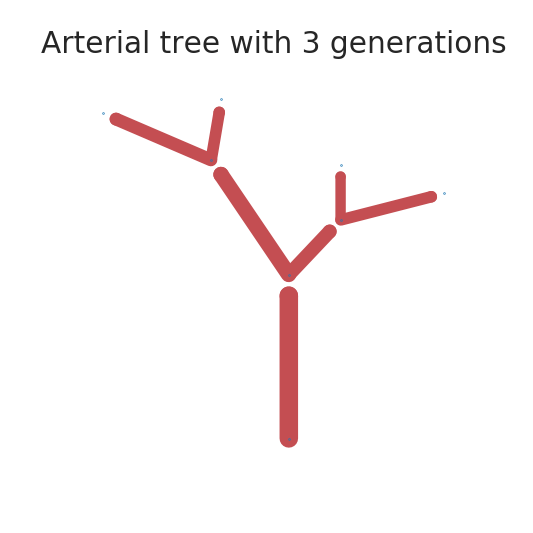

Width: 9.05, height: 20.70, max radius 0.10, min radius 0.06


In [2]:
# The arterial tree can be built randomly, with the direction (sign) of the branch being random.
# Keeping reproducability in mind we here override this behaviour
signs = np.tile([-1,1], 10).tolist()

N = 3

from generate_arterial_tree import make_arterial_tree
G = make_arterial_tree(N, directions = signs, gam=0.9, radius0=0.1)

pos = nx.get_node_attributes(G, 'pos')
pos2d = [coord[0:2] for coord in list(pos.values())]

radius = np.asarray(list(nx.get_edge_attributes(G, 'radius').values()))


fig, ax = plt.subplots(1,1, figsize=(4, 4))
nx.draw(G, pos2d, width=radius*100, edge_color='r', with_labels=False, node_size=0.1, arrowsize=0.1, ax=ax)

ax.set_xlabel('x [mm]', fontsize=16)
ax.set_ylabel('y [mm]', fontsize=16)
ax.set_title(f'Arterial tree with {N} generations', fontsize=16)


width = np.max(np.asarray(list(pos.values()))[:,0])
height = np.max(np.asarray(list(pos.values()))[:,1])
max_radius = np.max(radius)
min_radius = np.min(radius)

print(f'Width: {width:1.2f}, height: {height:1.2f}, max radius {max_radius:1.2f}, min radius {min_radius:1.2f}')

In [3]:
# Convert to FenicsGraph
G_ = nx.convert_node_labels_to_integers(G)

G = copy_from_nx_graph(G_)
G.make_mesh(8)

### Vasomotion

Vasomotion is the "spontaneuos" rhytmic contraction and expansion of arterial walls. Compared to cardiac wall motion, creates pulsations at low frequencies ($0.1$ Hz) and low wave speeds ($0.8$ mm/s). 

Following the same setup as in [2], let vasomotion be modelled as a travelling sinusoidal wave
$$
R_1(s,t) = R_1^0(s) + \gamma \sin(ks-wt)
$$
where $R_1^0(s)$ is the initial radius of the blood vessels.

The resulting wall speed can then be calculated as
$$
w = 2\pi R \partial_t R_1. 
$$

In [4]:
## Simulation parameters

lamda = 8 #wave length [mm]
k = 2*np.pi/lamda # wave number
w = 2.0*np.pi/10 #wave frequency 0.1Hz

gamma = 0.1

n_cycles = 3
time_steps = 25*n_cycles
T = 10*n_cycles
dt = T/time_steps

#### Implementing time-dependent functions in FEniCS 

The radius and wal motion functions are implemented directly as time and distance dependent functions in UFL.

In [5]:
## Fenics functions for radius, psi, and wall speed

P1 = FunctionSpace(G.mesh, 'CG', 1)
DG0 = FunctionSpace(G.mesh, 'DG', 0)

dist = DistFromSource(G, 0)
s = interpolate(dist, P1) # distance from source, computeded using bfs

t = Constant(0)

class InitRadius(UserExpression):
    def __init__(self, G, **kwargs):
        self.G = G
        super().__init__(**kwargs)
            
    def eval_cell(self, values, x, cell):
        edge = list(self.G.edges())[self.G.mf[cell.index]]
        radius = G.edges()[edge]['radius']
        values[0] = radius

        
R1_0 = InitRadius(G, degree=2)
R1_0_i = interpolate(R1_0, P1)

psi = sin(k*s-w*t)
psi_dt = -w*cos(k*s-w*t)

R1 = R1_0*(1+gamma*psi)
R1_dt = R1_0*gamma*psi_dt

R2 = 3*R1_0

circ = 2.0*np.pi*R1
f = circ*R1_dt

area_inv = 1/(3.14*(R2**2-R1**2))

import ufl
g = (water_properties['mu']/area_inv)*ufl.diff(f,s)

Q = 0.191
res = Constant(water_properties['nu']/Q)*(1/R1**4)

### Assigning network parameters

The cross-section area and resistance are assigned as edge attributes in the `FenicsGraph` network.

The resistance was computed using the cross-section in [6, Figure 1A], which models the characteristic elliptic shape of pial perivascular channels:
<img src="vinje.png" width=400 height=60 />

For the outer radius we assume $R_2=1.5 R_1^0$, and for cross-section area we use the simplified relation
$$
A = \pi (R_2^2-R_1^2).
$$

In [6]:
R2 = 1.5*R1_0
area_inv = 1/(np.pi*(R2**2 - R1**2))

for e in G.edges():
    radius1 = G.edges()[e]['radius']
    G.edges()[e]['Ainv'] = area_inv
    G.edges()[e]['Res'] = res


### Running the simulation

The model parameters are fed to the `HydraulicNetwork` model class, which contains the bilinear forms corresponding to the hydraulic network equations.  The function `time_stepping_stokes` discretizes the model in time and solves the resulting equations at each time step.

In [9]:
model = TimeDepHydraulicNetwork(G, p_bc=Constant(0), f=f, g=g, Ainv = area_inv, Res = res)

qps = time_stepping_stokes(model, t=t, t_steps = time_steps, T=T)

  0%|          | 0/74 [00:00<?, ?it/s]

In [10]:
# Plot solutions

pfile = File('vasomotion/p.pvd')
qfile = File('vasomotion/q.pvd')

for ix, sol in enumerate(qps[1:]):
    t = ix*dt
    
    q, p = sol
    p.rename('p', '0.0')
    q.rename('q', '0.0')
    pfile << (p,float(t))
    qfile << (q,float(t))

### Post-processing the flow

Finally, we are interested in tracking the flow over time; in particular, tracking the net flow of CSF through the network. To this end we record the cross-section flux at the root node and two leaf nodes.

In [11]:
# Record flow at the arterial tree root node and two leaf nodes.

root_v = 0 #inlet is the first vertex in the network

# find other boundary points 
adj_matrix = nx.adj_matrix(G).todense()
bps = np.where(np.sum(adj_matrix, axis=1)==0)[0]

leaf1_v, leaf2_v = bps[2:4]

root_pos = G.nodes()[root_v]['pos']
leaf1_pos = G.nodes()[leaf1_v]['pos']
leaf2_pos = G.nodes()[leaf2_v]['pos']

inflows, outflows, outflows2 = [], [], []
for ix, sol in enumerate(qps):
    q,p = sol
    inflows.append( q(root_pos))
    outflows.append( q(leaf1_pos))
    outflows2.append( q(leaf2_pos))

We then plot the cross-section flows $\hat{q}$ and net flows
$$
\int_0^t \hat{q}(\tau) \mathrm{d}\tau
$$
as a function of time:

<IPython.core.display.Javascript object>


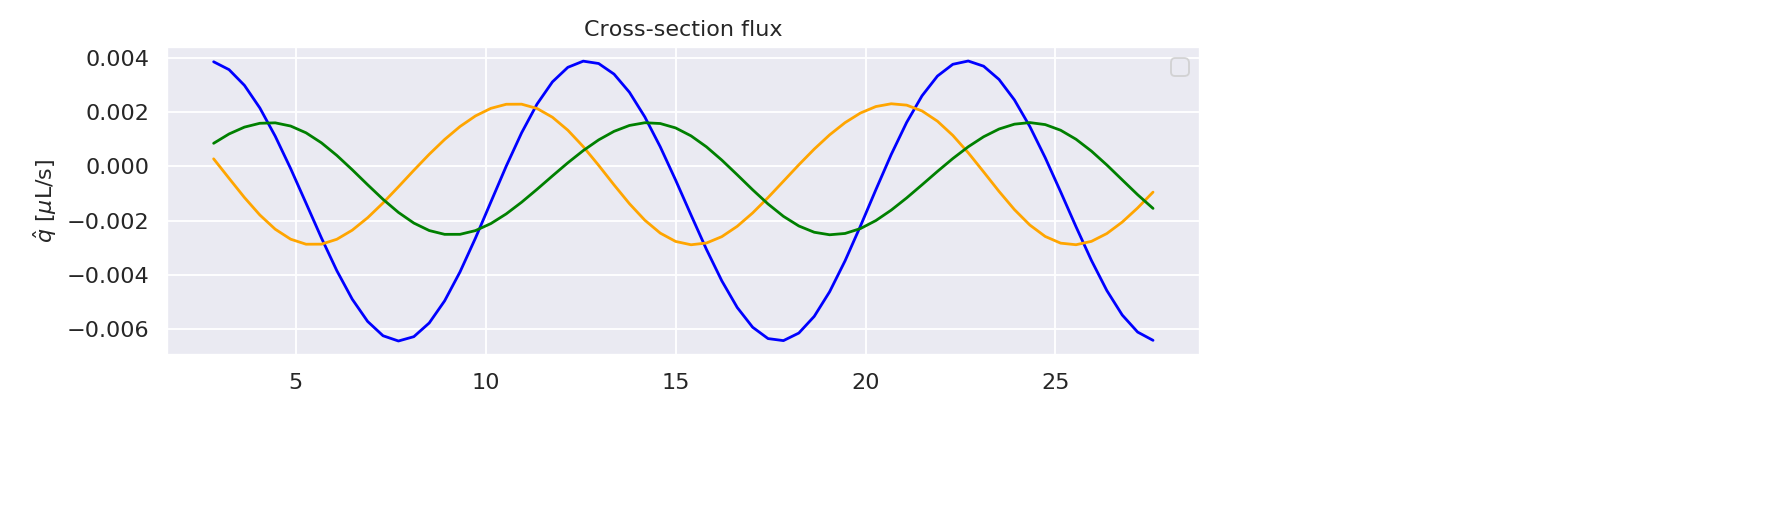

No handles with labels found to put in legend.


Text(0, 0.5, '$\\hat{q}$ [$\\mu$L/s]')

In [12]:
import seaborn as sns
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set(font_scale=1.1)

max_inflow = np.max(inflows[2:])
min_inflow = np.min(inflows[2:])
max_inflow_ixs = np.where(np.isclose(inflows, max_inflow, 0.5e-1)==True)[0]
min_inflow_ixs = np.where(np.isclose(inflows, min_inflow, 0.5e-1)==True)[0]

start = max_inflow_ixs[1]
end = min_inflow_ixs[-1]

ts = np.linspace(0, T, time_steps)


fig = plt.figure(figsize=(10, 3)) 
plt.title('Cross-section flux', fontsize=12)
plt.plot(ts[start:end], inflows[start:end], 'blue')
plt.plot(ts[start:end], outflows[start:end], 'orange')
plt.plot(ts[start:end], outflows2[start:end], 'green')
plt.legend()
plt.xlabel('time [s]', fontsize=12)
plt.ylabel('$\hat{q}$ [$\mu$L/s]', fontsize=12)

#plt.savefig('vasomotion_flow.png')

<IPython.core.display.Javascript object>


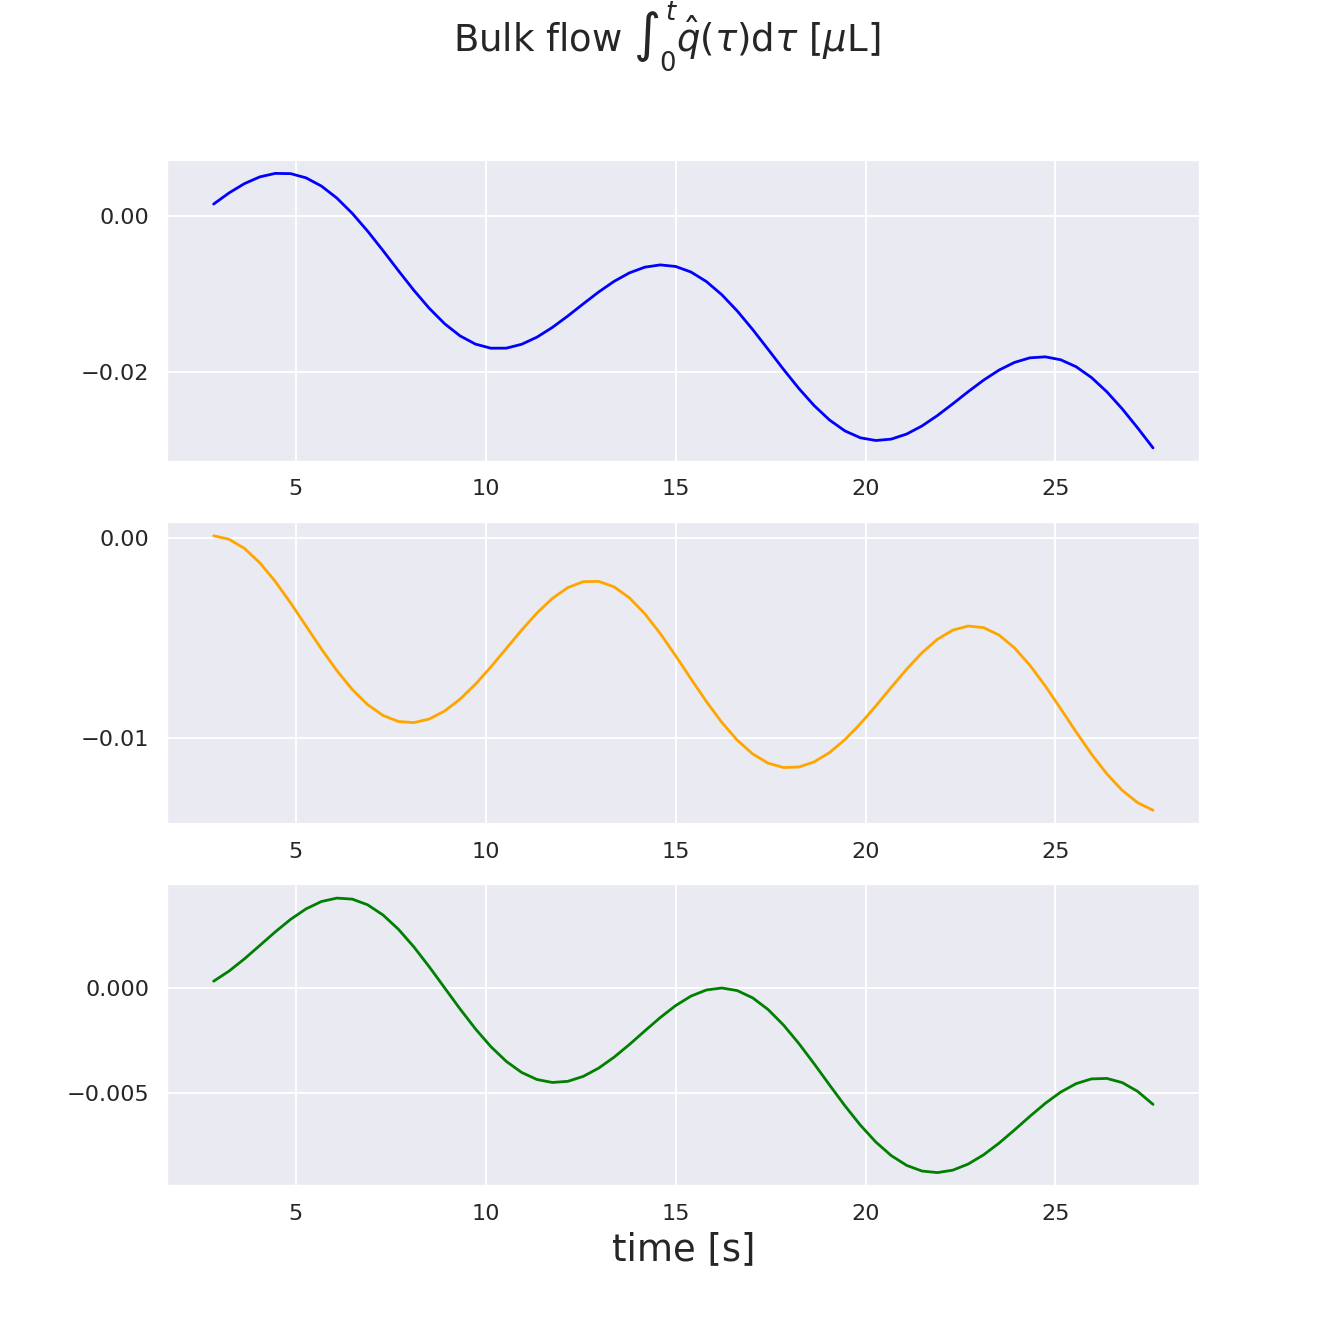

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(10,10)) # note we must use plt.subplots, not plt.subplot
fig.suptitle('Bulk flow $\int_0^t \hat{q}(\\tau)\mathrm{d}\\tau$ [$\mu$L]', y=1, fontsize=20)
sns.set(font_scale=2.2)

inflow_subset = np.asarray(inflows[start:end])
axs[0].plot(ts[start:end], np.cumsum(inflow_subset)*dt, 'blue')

outflow_subset = np.asarray(outflows[start:end])
axs[1].plot(ts[start:end], np.cumsum(outflow_subset)*dt, 'orange')

outflow2_subset = np.asarray(outflows2[start:end])
axs[2].plot(ts[start:end], np.cumsum(outflow2_subset)*dt, 'green')
axs[2].set_xlabel('time [s]', fontsize=20)

plt.subplots_adjust(hspace=0.2)
plt.savefig('vasomotion_netflow.png')

<IPython.core.display.Javascript object>


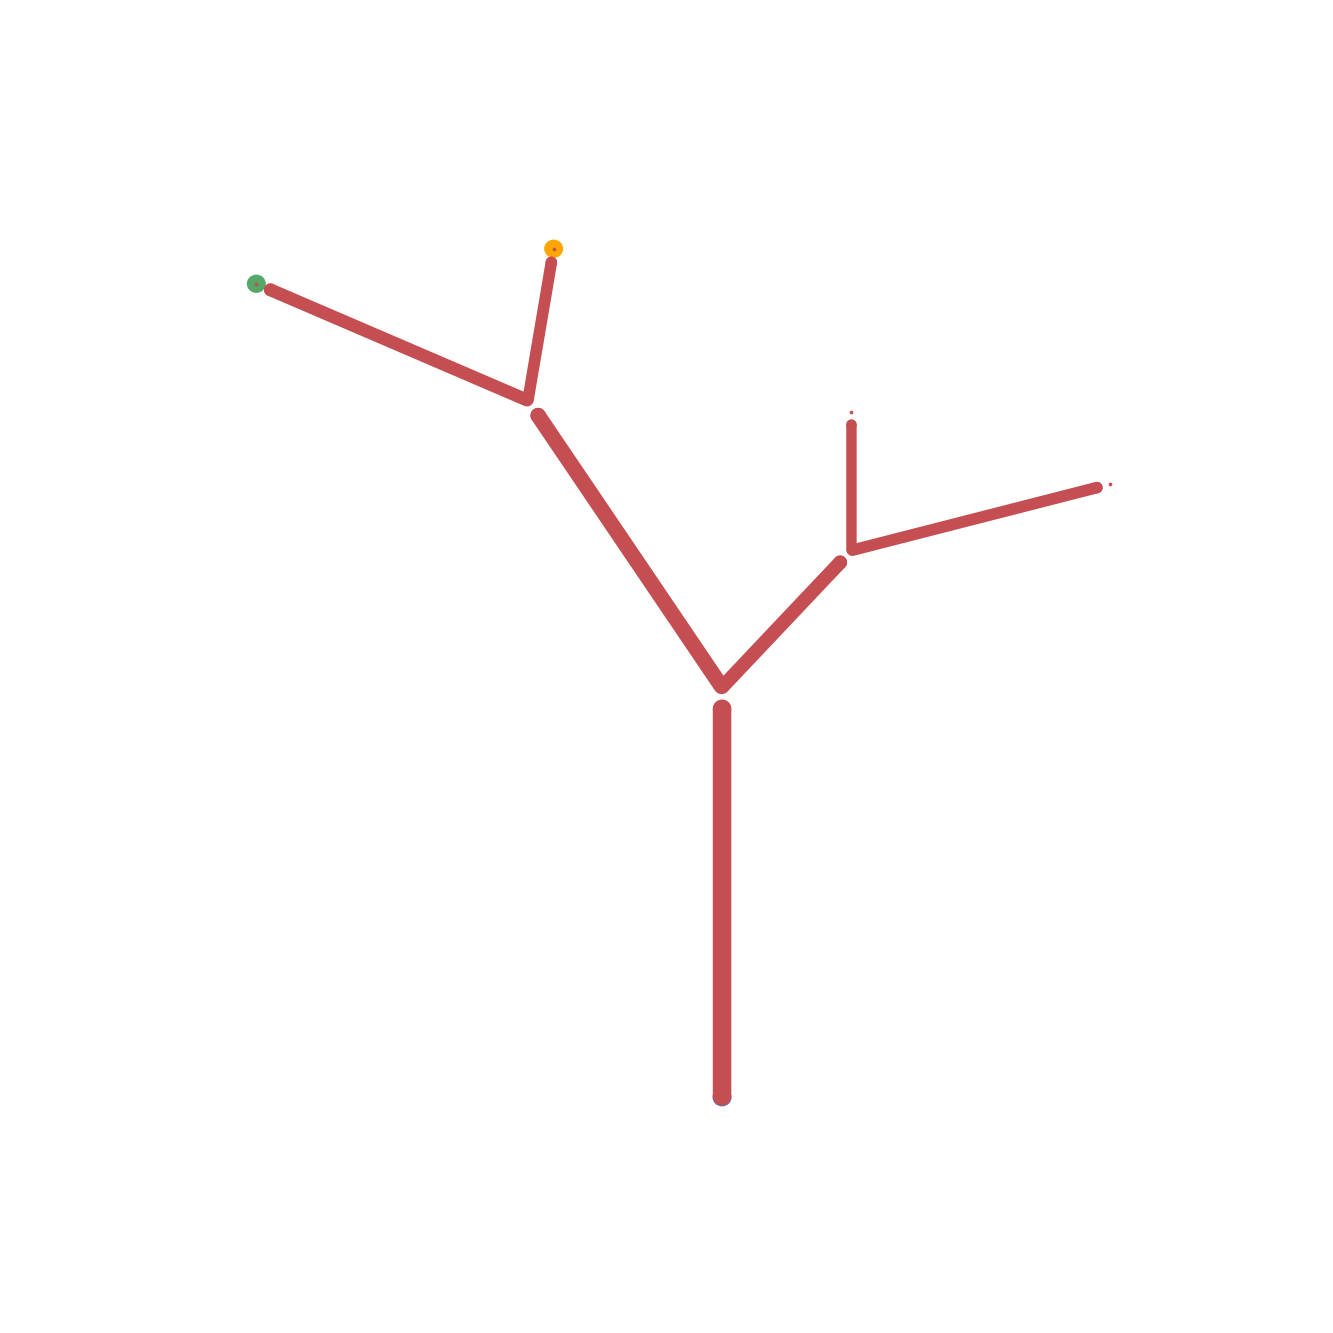

In [14]:
## Plot tree with the selected inlets and outlets marked

sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=(10,10)) # note we must use plt.subplots, not plt.subplot

pos = nx.get_node_attributes(G, 'pos')
pos2d = [coord[0:2] for coord in list(pos.values())]

radius = np.asarray(list(nx.get_edge_attributes(G, 'radius').values()))

circle1 = plt.Circle((root_pos[0], root_pos[1]), 0.2, color='b')
ax.add_patch(circle1)

circle1 = plt.Circle((leaf1_pos[0], leaf1_pos[1]), 0.2, color='orange')
ax.add_patch(circle1)

circle1 = plt.Circle((leaf2_pos[0], leaf2_pos[1]), 0.2, color='g')
ax.add_patch(circle1)

nx.draw(G, pos2d, width=radius*100, edge_color='r', node_color='r', with_labels=False, node_size=1, arrowsize=0.1, ax=ax)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel('x [mm]', fontsize=16)
ax.set_ylabel('y [mm]', fontsize=16)

plt.savefig('Arterial tree.png')


# References

[1] Vasomotion as a Driving Force for Paravascular Clearance in the Awake Mouse Brain
Susanne J van Veluw et. al. Neuron. 2020 Feb 5;105(3):549-561.e5. 

[2] Daversin-Catty C, Vinje V, Mardal K-A, Rognes ME (2020) The mechanisms behind perivascular fluid flow. PLoS ONE 15(12): e0244442. https://doi.org/10.1371/journal.pone.0244442

[3] Daversin-Catty C, Gjerde IG, Rognes ME (2022) Geometrically Reduced Modelling of Pulsatile Flow in Perivascular Networks. Frontiers in Physics, 10     

[4] Network models for pulsatile fluid flow in open or porous perivascular spaces. Gjerde I, Rognes ME, Wohlmuth B (in preparation)

[5] Hydraulic resistance of periarterial spaces in the brain. Tithof et al. Fluids Barriers CNS (2019) 16:19

[6] Brain solute transport is more rapid in periarterial than perivenous spaces. Vegard Vinje, Erik N. T. P. Bakker & Marie E. Rognes. Scientific Reports volume 11, Article number: 16085 (2021)